In [19]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import deque
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import Sequential 
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import math
from random import sample
from tensorflow.keras.optimizers import Adam
from tqdm import trange
import pandas as pd
import gc
import os

In [20]:
env= gym.make(
        "LunarLander-v2",
        continuous = False,
        gravity = -10.0,
        enable_wind = True,
        wind_power  = 5.0,
        turbulence_power = 0.5
    )

In [21]:
env.action_space.n
env.observation_space.shape

(8,)

In [22]:

GAMMA = 0.99
LEARNING_RATE = 2.5e-4

MEMORY_SIZE = 1000000
BATCH_SIZE = 64

EPSILON_MAX = 1.0
EPSILON_MIN = 0.01
EXPLORATION_DECAY = 0.995

In [23]:
state_space=5
obs_space=5
action_space=4
intermediate_dim=16

In [24]:
class QModel:
    def __init__(self, input_dim, output_dim, lr):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.Qpolicy = self.create()
        self.Qtarget = self.create() 
        self.Qtarget.set_weights(self.Qpolicy.get_weights())
        
    def create(self):
        model = Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(1,self.input_dim)))
        model.add(Dense(512,activation = 'relu',kernel_initializer='he_uniform'))
        model.add(Dense(256, activation = 'relu',kernel_initializer='he_uniform'))
        model.add(Dense(128, activation = 'relu',kernel_initializer='he_uniform'))
        model.add(Dense(self.output_dim, activation = 'linear',kernel_initializer='he_uniform'))
        model.compile(optimizer = RMSprop(learning_rate = self.lr, rho = 0.95, epsilon = 1e-7), loss = "mse", metrics = ['accuracy'])
        return model

In [25]:
class DQNSolver:
    def __init__(self, state_space,action_space, decay_coe = 0.998, 
                  memory_size = 10000,  C = 5,LEARNING_RATE=1e-4,GAMMA=1,EPSILON_MAX=1.0,EPSILON_MIN=0.01,BATCH_SIZE=64):
        
        #self.env = gym.make('CartPole-v0')

        self.states = state_space
        self.n_actions = action_space
        
        self.actions = [i for i in range(self.n_actions)]
        
        self.lr = LEARNING_RATE
        self.gamma = GAMMA
        self.epsilon = EPSILON_MAX
        self.decay_coe = decay_coe
        self.min_eps = EPSILON_MIN
        #self.episodes = episodes
        self.batch_size = BATCH_SIZE
        self.memory = deque(maxlen = memory_size) # replay memory 
        self.C = C
        
        self.terminal_state = False # end of the episode
        self.target_counter = 0 
        
        # Plot data
        #self.timestep = self.episodes / 10

        
        
        
        self.model = QModel(self.states, self.n_actions, self.lr)
        self.positive_rewards_list=[]
        # Smooth epsilon 
        # self.a = 0.35
        # self.b = 0.1
        # self.c = 0.01
    def find_positive_rewards(self):
        self.positive_rewards_list=[]
        for i,x in enumerate(self.memory):
            if x[2]>10:
                self.positive_rewards_list.append(i)
    def state_shape(self,states):
        states = np.array(states)
        return states.reshape(-1,*states.shape)
    def update_target_model(self):
        """
        Updates the current target_q_net with the q_net which brings all the
        training in the q_net to the target_q_net.
        :return: None
        """
        self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
    def decrement_epsilon(self):
        '''
        if self.epsilon > self.min_eps:
            self.epsilon *= self.decay_coe
        else:
            self.epsilon = self.min_eps
        '''
        # s_time = (time - self.a*self.episodes) / (self.b*self.episodes) 
        # cosh = np.cosh(math.exp(-s_time))
        # self.epsilon = 1 - (1/cosh + (time*self.c/self.episodes))
        if self.epsilon>self.min_eps:
            self.epsilon*=self.decay_coe
        else:
            self.epsilon=self.min_eps
    def forget(self):
        self.memory.clear()

    def remember(self, s, a, r, s_, done):
        self.memory.append([self.state_shape(s), a, r, self.state_shape(s_), done])
        
    def act(self, states):
        if np.random.random() > (1 - self.epsilon):
            action = np.random.choice(self.actions)
        else:
            states = self.state_shape(states)
            states.reshape(1,1,self.states)
#             states=[states]
#             states=np.array(states)
            #print(states.shape)
            action = np.argmax(np.array(self.model.Qpolicy.predict_on_batch(states)))
            
        return action
            
    def minibatch(self):
        return random.sample(self.memory, self.batch_size)
        # indices=[]
        # minibatch=[]
        # if(len(self.positive_rewards_list)>10):
        #     indices=random.sample(self.positive_rewards_list,10)
        #     for i in indices:
        #         minibatch.append(self.memory[i])
        #     minibatch=minibatch+random.sample(self.memory, self.batch_size-10)
        #     random.shuffle(minibatch)            
        #     return minibatch
        # else:
        #     for i in self.positive_rewards_list:
        #         minibatch.append(self.memory[i])
        #     minibatch=minibatch+random.sample(self.memory, self.batch_size-len(self.positive_rewards_list))
        #     random.shuffle(minibatch)            
        #     return minibatch


    

        #plt.savefig(r'RL/loss - e{}v2.png'.format(episode), dpi = 500)
        
    def train(self):
        # X - states passed to the NN, y - target
        
        X, y = [], []
        
        if len(self.memory) >= self.batch_size: 
            SARS = self.minibatch()
        
            s = self.state_shape([row[0] for row in SARS])
            s=s.reshape(BATCH_SIZE,1,state_space)
            #print(s.shape)
            qvalue = np.array(self.model.Qpolicy.predict_on_batch(s))
            #print(qvalue)

            s_ = self.state_shape([row[3] for row in SARS])
            s_=s_.reshape(BATCH_SIZE,1,state_space)
            future_qvalue = np.array(self.model.Qtarget.predict_on_batch(s_))
            #print("2")
            #print(future_qvalue)

            for index, (state, action, reward, state_, done) in enumerate(SARS):
                if done == True:
                    Qtarget = reward
                else:
                    Qtarget = reward + self.gamma * np.max(future_qvalue[index][0])
            
                qcurr = qvalue[index][0]
                #print(qcurr)
                qcurr[int(action)] = Qtarget 
                #print(qcurr)
                X.append(state)
                y.append(qcurr)
#             X_dataset=tf.data.Dataset.from_tensor_slices(X).batch(64)
#             y_dataset=tf.data.Dataset.from_tensor_slices(y).batch(64)
#             final_dataset=tf.data.Dataset.zip((X_dataset, y_dataset))
            #X, y = np.array(X).reshape(self.batch_size,1,self.states), np.array(y).reshape(self.batch_size, 1, self.n_actions)
            
           #print(X.shape,"   ",y.shape  )                          
            #loss = self.model.Qpolicy.fit(final_dataset,verbose=0)   
            X, y = np.array(X).reshape(self.batch_size,1,self.states), np.array(y).reshape(self.batch_size, 1, self.n_actions)
           # print(self.model.Qpolicy.predict_on_batch(X))
           #print(X.shape,"   ",y.shape  )                          
            self.model.Qpolicy.train_on_batch(X, y,return_dict=True)
            
            #self.history.append(loss.history['loss'][0])
            
                
            # if self.terminal_state:
            #     self.target_counter+=1

            # # C -> target network update frequency
            # if self.target_counter > self.C: 
            #     self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
            #     self.target_counter = 0 

                
  

In [26]:
dqn_solver=DQNSolver(state_space=state_space,action_space=action_space)


In [27]:
scores=[]
no_train=[]


In [28]:
s=env.reset()
s=s[0]
print(s)

[-0.00520973  1.4058657  -0.5274812  -0.22465114  0.00583292  0.11536244
  0.          0.        ]


In [29]:
s=[s[0],s[1],s[4],s[6],s[7]]
print(s)

[-0.005209732, 1.4058657, 0.0058329245, 0.0, 0.0]


In [30]:
#dqn_solver.memory[0]

In [31]:
#qn_solver.state_shape(dqn_solver.memory[0][0])

In [32]:
def get_obs(state):
    if(len(state)==8):
        return [state[0],state[1],state[4],state[6],state[7]]
    else:
        print("error")

In [33]:
def training(dqn_solver,n_episodes=5000,maxt=2000):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
     # last 100 scores
    trains=0
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        state=state[0]
        state=get_obs(state)
        score = 0

        done=False

        for t in tqdm(range(maxt),leave=False,desc=str(i_episode)):
            action = dqn_solver.act(state)
            next_state, reward, done, _,_ = env.step(action)
            next_state=get_obs(next_state)
            dqn_solver.remember(state,action,reward,next_state,done)

            dqn_solver.train()
            trains+=1
            state = next_state
            score += reward
            if done:
                break
            
        dqn_solver.decrement_epsilon()
        scores.append(score)
        no_train.append(trains)             # save most recent score
        if(i_episode%2==0):
            dqn_solver.update_target_model()
        if(i_episode%20==0):
            print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, score, end=""))




In [34]:
training(dqn_solver)

4:   0%|          | 9/2000 [00:01<03:46,  8.81it/s]  

Episode 20	Score: -141.06


Episode 40	Score: -74.71


Episode 60	Score: -364.09


Episode 80	Score: -87.25


Episode 100	Score: -68.02


Episode 120	Score: -55.72


Episode 140	Score: -48.04


Episode 160	Score: -201.32


Episode 180	Score: -97.76


Episode 200	Score: -415.41


Episode 220	Score: -186.45


Episode 240	Score: -60.51


Episode 260	Score: -107.19


Episode 280	Score: -105.34


Episode 300	Score: -49.18


Episode 320	Score: -25.31


Episode 340	Score: -93.62


Episode 360	Score: -142.70


Episode 380	Score: -116.67


Episode 400	Score: -102.68


Episode 420	Score: -160.20


Episode 440	Score: -75.76


Episode 460	Score: -71.75


Episode 480	Score: -92.34


Episode 500	Score: -176.57


Episode 520	Score: -45.33


Episode 540	Score: -39.92


Episode 560	Score: -103.28


Episode 580	Score: -93.00


Episode 600	Score: -525.19


Episode 620	Score: -46.37


Episode 640	Score: -159.21


Episode 660	Score: -346.72


Episode 680	Score: -89.53


Episode 700	Score: -150.20


Episode 720	Score: -497.10


Episode 740	Score: -187.77


Episode 760	Score: -55.01


Episode 780	Score: -96.10


Episode 800	Score: -97.53


Episode 820	Score: -165.49


Episode 840	Score: -84.91


Episode 860	Score: -126.17


Episode 880	Score: -135.53


Episode 900	Score: -72.33


Episode 920	Score: -202.54


Episode 940	Score: -61.92


Episode 960	Score: -21.78


Episode 980	Score: -501.74


Episode 1000	Score: -167.90


Episode 1020	Score: -543.58


Episode 1040	Score: -20.28


Episode 1060	Score: 10.00


Episode 1080	Score: -142.16


Episode 1100	Score: 9.00


Episode 1120	Score: -175.14


Episode 1140	Score: -376.67


Episode 1160	Score: -113.46


Episode 1180	Score: -1.75


Episode 1200	Score: -359.48


Episode 1220	Score: -86.34


Episode 1240	Score: -223.73


Episode 1260	Score: -156.99


Episode 1280	Score: -207.82


Episode 1300	Score: -314.08


Episode 1320	Score: -58.82


Episode 1340	Score: -59.43


Episode 1360	Score: -32.07


Episode 1380	Score: -83.19


Episode 1400	Score: -146.92


Episode 1420	Score: 11.63


Episode 1440	Score: -102.82


Episode 1460	Score: -181.16


Episode 1480	Score: -128.85


Episode 1500	Score: -48.17


Episode 1520	Score: -127.16


Episode 1540	Score: -216.12


Episode 1560	Score: -127.73


Episode 1580	Score: 3.06


Episode 1600	Score: -134.80


Episode 1620	Score: -120.70


Episode 1640	Score: -92.89


Episode 1660	Score: -74.36


Episode 1680	Score: -238.32


Episode 1700	Score: -135.66


Episode 1720	Score: -174.37


Episode 1740	Score: -126.01


Episode 1760	Score: -57.33


Episode 1780	Score: -179.28


Episode 1800	Score: -36.82


Episode 1820	Score: -463.54


Episode 1840	Score: -165.09


Episode 1860	Score: -24.52


Episode 1880	Score: -75.76


Episode 1900	Score: -66.97


Episode 1920	Score: 42.60


Episode 1940	Score: -131.94


Episode 1960	Score: -123.68


Episode 1980	Score: -281.92


Episode 2000	Score: -123.99


Episode 2020	Score: -172.99


Episode 2040	Score: -281.82


Episode 2060	Score: -176.28


Episode 2080	Score: -1.30


Episode 2100	Score: -53.00


Episode 2120	Score: -236.94


Episode 2140	Score: -119.38


Episode 2160	Score: 275.73


Episode 2180	Score: -20.12


Episode 2200	Score: -129.21


Episode 2220	Score: -113.34


Episode 2240	Score: -11.06


Episode 2260	Score: -487.49


Episode 2280	Score: -108.47


Episode 2300	Score: -71.53


Episode 2320	Score: -132.02


Episode 2340	Score: -321.42


Episode 2360	Score: -170.79


Episode 2380	Score: -43.11


Episode 2400	Score: -236.59


Episode 2420	Score: -409.15


Episode 2440	Score: -101.23


Episode 2460	Score: -133.69


Episode 2480	Score: -46.64


Episode 2500	Score: 7.43


Episode 2520	Score: -394.19


Episode 2540	Score: -247.97


Episode 2560	Score: -271.49


Episode 2580	Score: -240.99


Episode 2600	Score: -559.73


Episode 2620	Score: -244.60


Episode 2640	Score: -358.16


Episode 2660	Score: -150.96


Episode 2680	Score: -60.14


Episode 2700	Score: -73.11


Episode 2720	Score: -126.13


Episode 2740	Score: -100.83


Episode 2760	Score: -100.73


Episode 2780	Score: -69.18


Episode 2800	Score: -47.74


Episode 2820	Score: -128.92


Episode 2840	Score: -55.51


Episode 2860	Score: -530.46


Episode 2880	Score: -84.11


Episode 2900	Score: -34.47


Episode 2920	Score: -302.59


Episode 2940	Score: -354.94


Episode 2960	Score: -214.28


Episode 2980	Score: -94.22


Episode 3000	Score: 17.75


Episode 3020	Score: -264.68


Episode 3040	Score: -69.49


Episode 3060	Score: -114.08


Episode 3080	Score: -60.41


Episode 3100	Score: -16.42


Episode 3120	Score: -16.54


Episode 3140	Score: -74.97


Episode 3160	Score: -6.71


Episode 3180	Score: -9.91


Episode 3200	Score: -282.97


Episode 3220	Score: -82.66


Episode 3240	Score: -34.03


Episode 3260	Score: -27.98


Episode 3280	Score: -48.22


Episode 3300	Score: -44.65


Episode 3320	Score: 2.67


Episode 3340	Score: -72.08


Episode 3360	Score: -21.83


Episode 3380	Score: -35.97


Episode 3400	Score: -69.24


Episode 3420	Score: -17.08


Episode 3440	Score: -97.97


Episode 3460	Score: -300.57


Episode 3480	Score: 34.27


Episode 3500	Score: -417.92


Episode 3520	Score: -72.39


Episode 3540	Score: -72.49


Episode 3560	Score: -60.72


Episode 3580	Score: -346.57


Episode 3600	Score: -143.72


Episode 3620	Score: -25.01


Episode 3640	Score: -19.63


Episode 3660	Score: -12.15


Episode 3680	Score: -255.27


Episode 3700	Score: -149.78


Episode 3720	Score: 35.79


Episode 3740	Score: -239.04


Episode 3760	Score: -65.33


Episode 3780	Score: 41.19


Episode 3800	Score: -83.60


Episode 3820	Score: -48.23


Episode 3840	Score: 23.94


Episode 3860	Score: -20.35


Episode 3880	Score: -55.31


Episode 3900	Score: -22.53


Episode 3920	Score: -68.99


Episode 3940	Score: 28.98


Episode 3960	Score: -187.90


Episode 3980	Score: -21.13


Episode 4000	Score: -122.68


Episode 4020	Score: -220.52


Episode 4040	Score: -147.29


Episode 4060	Score: -49.70


Episode 4080	Score: -191.08


Episode 4100	Score: -10.86


Episode 4120	Score: -91.54


Episode 4140	Score: -160.24


Episode 4160	Score: -315.89


Episode 4180	Score: -542.07


Episode 4200	Score: -82.98


Episode 4220	Score: 11.85


Episode 4240	Score: -93.77


Episode 4260	Score: -78.47


Episode 4280	Score: -73.99


Episode 4300	Score: -241.03


Episode 4320	Score: -0.50


Episode 4340	Score: -113.42


Episode 4360	Score: -152.01


Episode 4380	Score: -155.81


Episode 4400	Score: -299.61


Episode 4420	Score: -157.16


Episode 4440	Score: -29.60


Episode 4460	Score: -202.35


Episode 4480	Score: -157.63


Episode 4500	Score: -187.82


Episode 4520	Score: -33.65


Episode 4540	Score: -44.12


Episode 4560	Score: -203.82


Episode 4580	Score: -239.84


Episode 4600	Score: -292.71


Episode 4620	Score: -92.66


Episode 4640	Score: -9.66


Episode 4660	Score: -27.01


Episode 4680	Score: -250.52


Episode 4700	Score: -133.57


Episode 4720	Score: -201.33


Episode 4740	Score: -180.57


Episode 4760	Score: -88.92


Episode 4780	Score: -6.63


Episode 4800	Score: -37.51


Episode 4820	Score: -141.47


Episode 4840	Score: -327.51


Episode 4860	Score: -25.33


Episode 4880	Score: -314.99


Episode 4900	Score: -146.80


Episode 4920	Score: -79.05


Episode 4940	Score: -51.32


Episode 4960	Score: -113.62


Episode 4980	Score: -74.65


Episode 5000	Score: -147.20


In [17]:
dqn_solver.epsilon

0.01

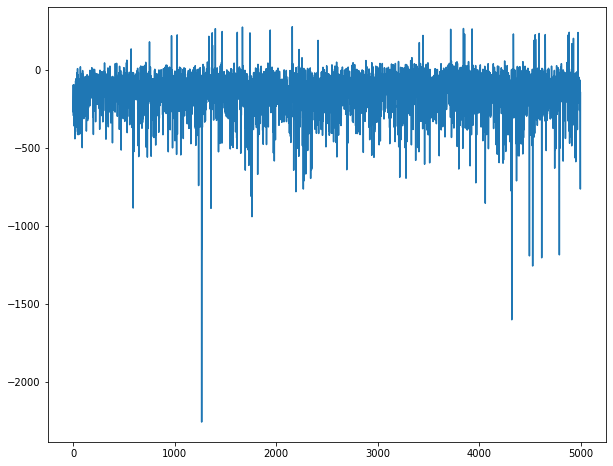

In [35]:
plt.rcParams['figure.figsize']=[10,8]
plt.plot(scores)

In [36]:
df=pd.DataFrame(scores)
df.to_csv('rewards_only_dqn_lunar_PO_30_05.csv')

In [37]:
for score in scores:
    if(score>=200):
        print(score)

217.92649302322445
223.01793351562034
213.8774491669575
236.4066972267861
262.9901964288802
244.64763726549955
239.3592591199428
273.2610493878535
235.9677514742475
254.07302871467613
275.7334746201825
219.5580319467911
259.09086504258823
264.07178921595266
228.19585406159916
261.2364094219972
228.97985097328205
224.1086612813453
232.3123605701066
225.08960348460593
221.41151301931387
239.5611853383895
200.84179292592205
238.30360446210435


In [21]:
import pandas as pd
df=pd.DataFrame(scores)
df.columns=['scores']
df.to_csv('rewards_only_dqn_PO_lunar_07_05.csv')

In [ ]:
df

,scores
0,-91.292541
1,-195.996561
2,-94.875289
3,-210.787841
4,-426.727009
...,...
995,-126.470976
996,-247.489550
997,-93.269558
998,-66.920901


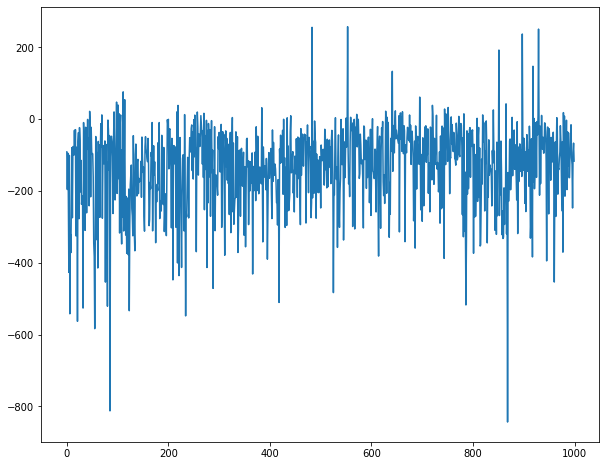

In [ ]:
plt.rcParams['figure.figsize']=[10,8]
plt.plot(scores)

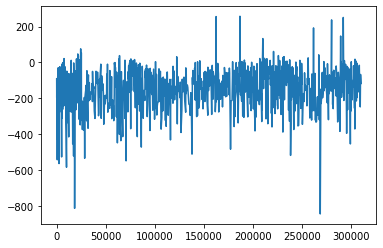

In [ ]:
import matplotlib.pyplot as plt
plt.plot(no_train,scores)

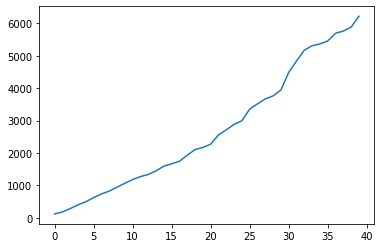

In [ ]:
plt.plot(no_train[0:40])

In [ ]:
ls=[]
for x in scores:
    if x>0:
        ls.append(x)
    else:
        ls.append(0.0)

In [27]:

df['moving_avg']=df.scores.rolling(10,min_periods=1).mean()

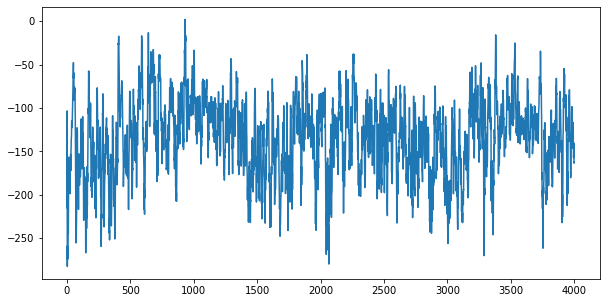

In [28]:
plt.rcParams['figure.figsize']=[10,5]

plt.plot(df['moving_avg'])

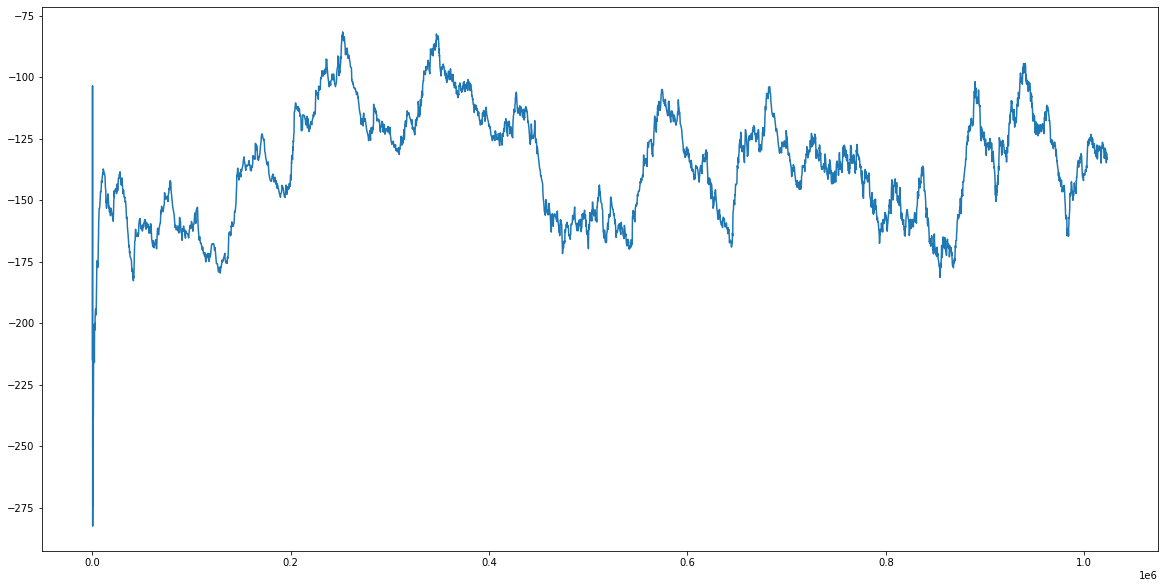

In [25]:
plt.plot(no_train,df['moving_avg'])